### 시계열 분석
시간의 흐름에 따라 기록된 데이터를 바탕으로 미래의 변화에 대한 추세를 분석하는 방법이다. 시간을 고려하기 때문에 시간에 따라 데이터의 추세가 어떠한지 시간 외에 어떠한 외부요인이 데이터에 영향을 미치는지를 나누어 생각할 수 있어야 한다.

##### 1) 시계열 분해
시계열 자료를 추세(Trend), 계절성(Seasonality), 잔차(Residual)로 분해하는 기법이다.
- 시간요인 : 추세, 계절성
- 외부요인 : 잔차(불규칙요인)


시계열의 주기적 반복/계절성이 있는지에 따라 Additive 모형과 Multiplicative 모형 중 어떤 모형이 더 적합할지 판단한다.
- Additive : 추세와 계절성이 별개로 존재하는 경우
- Multiplicative : 추세에 따라 계절성이 있는 경우


<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*LdeXlKrgNkFUjOhnO4Zzaw.jpeg" width='65%' height='65%'>

###### 출처 및 참고 : [medium - sigmundojr](https://sigmundojr.medium.com/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7)

In [1]:
import pandas as pd
import warnings

data = pd.read_csv('./data/arima_data.csv', names = ['day', 'price'])
data.head()

,day,price
0,2013-01-01,3794
1,2013-02-01,3863
2,2013-03-01,5190
3,2013-04-01,5783
4,2013-05-01,6298


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   day     60 non-null     object
 1   price   60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


데이터를 확인했을 때, day 값이 object 문자열이므로 datetime으로 변환해야 한다.

In [3]:
data['day'] = pd.to_datetime(data['day'],format="%Y-%m-%d")
data.set_index('day', inplace=True)
data.head(3)

,price
day,
2013-01-01,3794
2013-02-01,3863
2013-03-01,5190


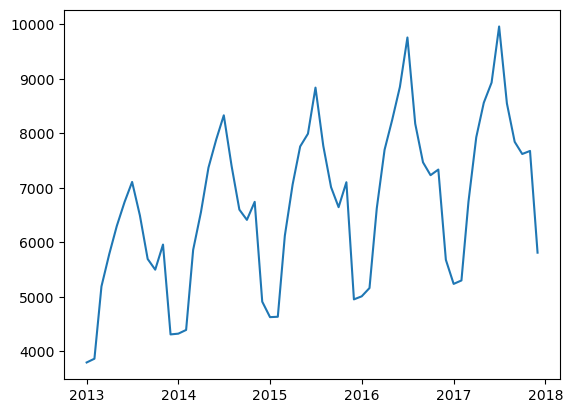

In [4]:
import matplotlib.pyplot as plt
plt.plot(data.index,data['price'])

원본 데이터를 시각화해보면, 추세에 따라 계절성이 존재하는 것을 볼 수 있다. 시간이 지날수록 변동이 커지므로 Multiplicative를 적용하여 시계열 분해를 할 수 있다.

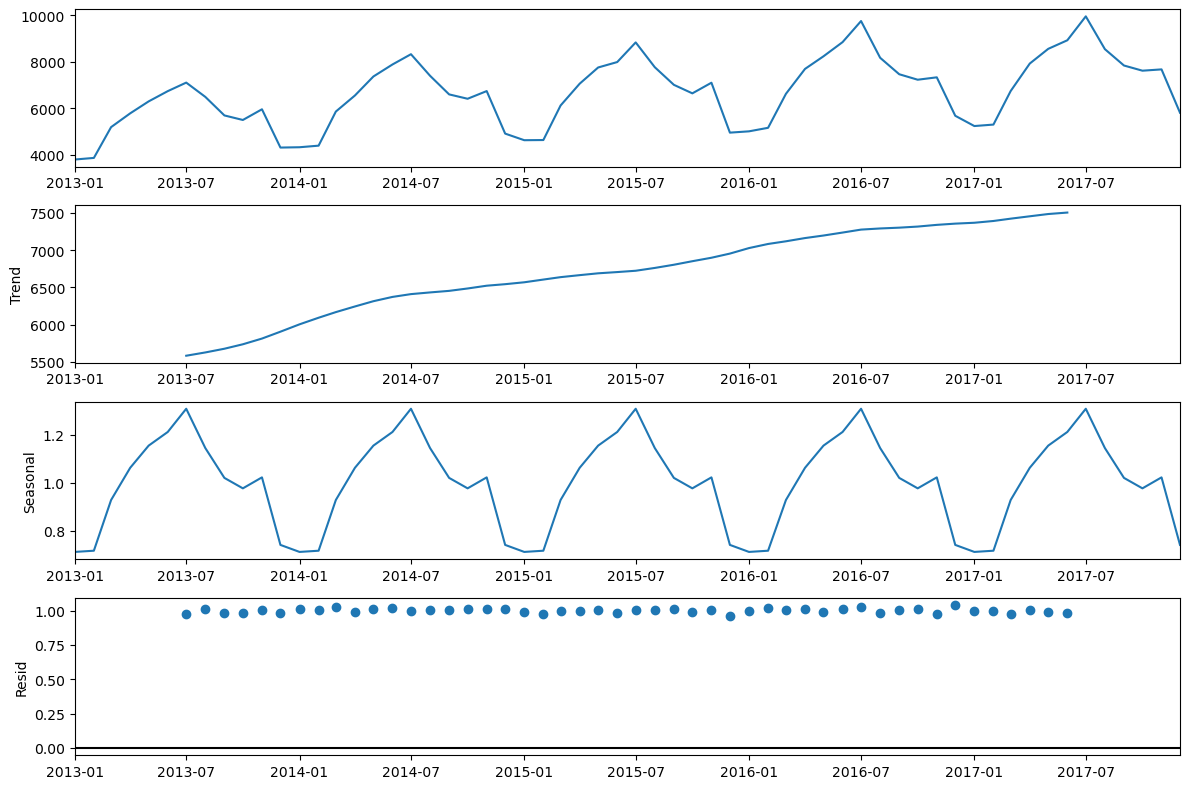

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts = data
result = seasonal_decompose(ts, model='multiplicative')
plt.rcParams['figure.figsize'] = [12, 8]
result.plot()
plt.show()

seasonal_decompose 함수로 시계열 분해한 결과 값을 보면, 해당 데이터는 Trend(추세)와 Seasonal(계절성)이 명확히 존재하며, 불규칙요인은 거의 없음을 알 수 있다.

##### 2) 정상성 변환
정상성(Stationary)이란 평균, 분산이 시간에 따라 일정한 성질을 가지고 있다는 것이다. 즉, 시계열 데이터의 특성이 시간의 흐름에 따라 변하지 않는 상태를 의미한다.
- 앞서 보았던 시계열 분해에서 추세나 계절성이 있는 시계열은 정상 시계열이 아닌 것임
- 비정상 시계열의 경우 ARIMA 모형을 적용시킬 수 없으므로 정상시계열로 변환(로그변환/차분)해야함

  - 로그변환 : 분산(변동폭)이 일정하지 않은 경우에 사용함
  - 차분 : 로그변환 후 추세, 계절성이 존재하는 경우 추세와 계절성을 없애기 위해 이용함

In [4]:
import pandas as pd
data = pd.read_csv('./data/arima_data.csv', names = ['day', 'price'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   day     60 non-null     object
 1   price   60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [5]:
data['day'] = pd.to_datetime(data['day'],format="%Y-%m-%d")
data.set_index('day', inplace=True)
data.head(3)

,price
day,
2013-01-01,3794
2013-02-01,3863
2013-03-01,5190


정상성을 검정하기 위해서는 Augmented Dickey-Fuller test를 해야한다.
- (H0) 데이터가 정상성을 갖지 않는다
- (H1) 데이터가 정상성을 갖는다

In [6]:
from statsmodels.tsa.stattools import adfuller

#Train, Test 데이터 구분
training = data[:"2016-12-01"]
test = data.drop(training.index)

# regression
# nc 또는 c : 데이터에 아무런 추세가 보이지 않는 경우
# ct 또는 ctt : 명확한 추세가 보이는 경우
adf = adfuller(training, regression='ct')
print('ADF Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

ADF Statistic: -1.9997199341328131
p-value : 0.6015863303793997


데이터를 train과 test로 분리한 뒤 원본 데이터가 정상성을 갖고 있는지 검정해보았다.

우상향 추세를 보인 데이터이므로 ct값을 적용하여 regression 검정 결과, p-value가 유의수준 0.05보다 높게 나타났으므로 귀무가설을 기각할 수 없다. 즉, 해당 데이터는 정상성을 갖지 않는다고 할 수 있다.

비정상 시계열을 정상시계열로 변환시키기 위해서는 1차차분 혹은 로그변환을 해야한다.

<AxesSubplot: xlabel='day'>

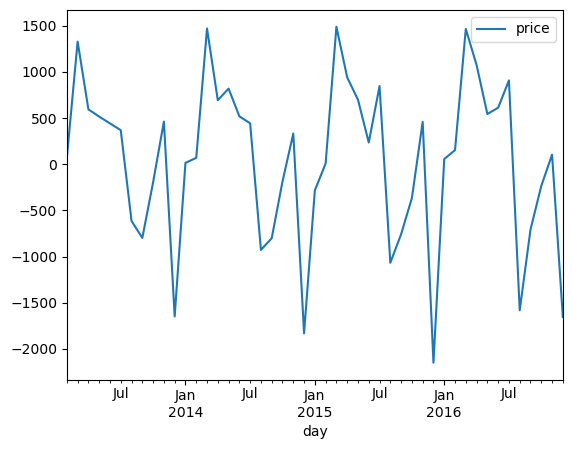

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_data = training.diff(1)  # 1차 차분
diff_data = diff_data.dropna()
diff_data.plot()

In [8]:
# 정상시계열 변환 후 정상성 만족하는지 검정
adf = adfuller(diff_data, regression="c")
print('ADF Statistic: {}'.format(adf[0]))
print('p-value : {}'.format(adf[1]))

ADF Statistic: -12.094547576926411
p-value : 2.0851606399612174e-22


1차 차분한 그래프가 추세를 보이지 않기 때문에 정상성 검정 시 regression 매개변수 값에 "c"를 적용하여 검정해야 한다.

검정결과 p-value는 0.05보다 작으므로 귀무가설을 기각할 수 있다. 

1차 차분으로 정상시계열로 변환하였으니 AR/MA모형을 알아보자

##### 3) AR(Auto Regressive) : 자기회귀모형
현 시점의 데이터를 이전의 데이터들의 상관성으로 나타내는 모형으로, 과거의 값이 현재의 값에 얼마나 영향을 미쳤는지를 파악하는 것이다. (만약 과거 값이 현재 값에 영향을 미치지 않는다면 모형 성능이 낮아진다.)

이때 최적의 성능을 가지는 모델을 만들 수 있는 과거값을 찾게되며, 이 값을 p라고 하며 AR(p) 모형이라 부른다.

- ACF(Auto Correlation Function) : 자기상관 함수로 시차에 따른 자기상관성을 의미한다. ACF값을 시차에 따른 그래프로 시각화해보면 최적의 p값을 찾을 수 있다. 비정상 시계열일 경우 ACF값은 느리게 0에 접근하며, 양수값을 가질 수도 있다. 하지만 정상시계열일 경우 ACF값이 빠르게 0으로 수렴하며 0으로 수렴할 때에 시차를 p값으로 설정한다.

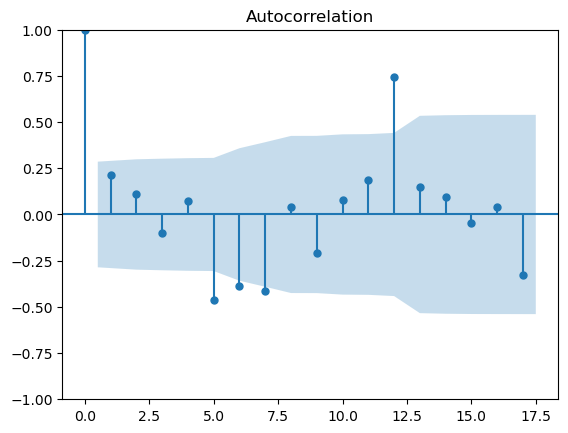

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(diff_data) #AR(p)의 값 확인 가능
plt.show()

ACF값을 확인해보면 시차 2 이후에 0에 수렴하는 것을 알 수 있다. 그러므로 AR모형에서 최적 p값은 2로 설정할 수 있다.

##### 4) MA(Moving Average)
과거의 예측 오차들의 가중이동평균으로 현재 시점의 데이터를 표현하는 모형이다. 즉, 과거의 예측 오차를 이용하여 미래를 예측하는 모형이라고 할 수 있다. 과거의 예측오차들에 따라 가중이동평균은 달라지기 때문에 MA 모형은 최적의 모형이 되는 구간을 구하는 것이 중요하다. MA모형이 최적이 되게끔 하는 변수 값이 q이며 MA(q) 모형이라고 한다.

- PACF(Partial Auto Correlation Function) : 편자기상관함수로 ACF와 다르게 시차가 다른 두 시계열 데이터간 순수한 상호연관성을 나타낸다. PACF값이 0에 수렴할 때 q값을 MA모형의 q값으로 설정한다.

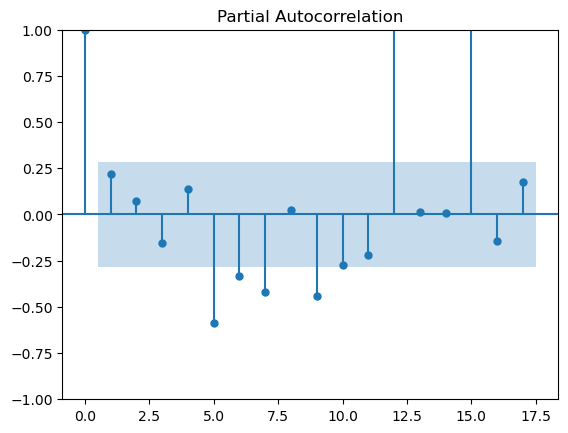

In [15]:
plot_pacf(diff_data) #MA(q)의 값 확인 가능
plt.show()

PACF값을 확인해보면, 시차 2이후에 0에 수렴하는 것을 알 수 있다. 그러므로 MA모형에서 최적 q값은 2로 설정할 수 있다.

##### 5) ARIMA(Auto Regressive Intergrated Moving Average)
비정상적 시계열 자료에 대해 분석하는 모형이다. 차분을 사용하여 비정상 시계열을 정상시계열로 만들고 정상시계열의 경우 AR모형과 MA모형이 상호변환 가능하기 때문에 두 모형을 결합하여 과거의 시점의 데이터로 현재 혹은 미래 시점의 데이터를 예측하는 모형이다.

ARIMA 모형은 시계열 자료 외 다른 자료가 없을 때, 그 변동 상태를 확인할 수 있며 어떠한 시계열에도 적용 가능한 모델이라는 장점이 있다.

- ARIMA 모형 파라미터 : p는 ACF, d는 차분 횟수, q는 PACF

In [36]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(training, order=(2,0,2),trend='ct') # 앞서 사용한 파라미터를 이용
res = model.fit()
res.summary()

c:\Users\heo\.conda\envs\adp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\heo\.conda\envs\adp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\heo\.conda\envs\adp\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\heo\.conda\envs\adp\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\heo\.conda\envs\adp\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertib

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   48
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -380.820
Date:                Mon, 06 Mar 2023   AIC                            775.639
Time:                        18:49:24   BIC                            788.738
Sample:                    01-01-2013   HQIC                           780.589
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5282.3542    701.541      7.530      0.000    3907.359    6657.350
x1            45.2774     23.228      1.949      0.051      -0.250      90.804
ar.L1         -0.4791      0.167     -2.872      0.004      -0.806      -0.152
ar.L2          0.5167      0.169      3.053      0.002       0.185       0.848
ma.L1          1.9570      0.212      9.223      0.000       1.541       2.373
ma.L2          0.9858      0.214      4.598      0.000       0.566       1.406
sigma2      3.832e+05      0.122   3.15e+06      0.000    3.83e+05    3.83e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 1.46
Prob(Q):                              0.75   Prob(JB):                         0.48
Heteroskedasticity (H):               1.37   Skew:                            -0.43
Prob(H) (two-sided):                  0.53   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.96e+23. Standard errors may be unstable.
"""

training 셋을 (2,0,2)로 학습시킨 결과이다. 

AIC와 AR/MA 모델의 p-valude를 깊게 살펴봐야 한다. AIC는 다른 모델과 비교할 때 사용할 수 있으며, 작을수록 성능이 좋다. 하지만 AIC가 절대적 기준이 되어서는 안된다.

다음으로 coef(계수)에서 p-value가 0.05 이하라면, AR모형과 MA 모형을 사용할 수 있다는 것이다. L1, L2는 사용하는 시차의 개념이다. 만약 p가 5라면 AR.L1~L5까지 변수를 모델에서 사용한다.

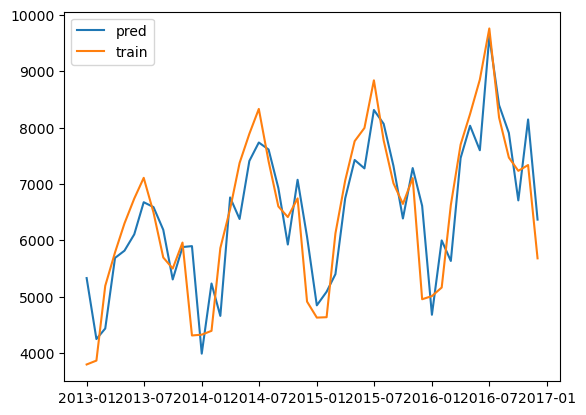

In [40]:
plt.plot(res.predict(), label="pred")
plt.plot(training, label="train")
plt.legend()
plt.show()

해당 모델 학습 정도를 보기위해, 학습시킨 데이터를 예측해보면, 그래프 모양은 거의 일치하므로 과소적합은 의심되지 않는다.

학습된 모델을 가지고 2017년 데이터를 예측해보자. ARIMA에서 예측할 때는 predict() 함수보다 forecast()함수를 주로 이용한다. 예측할만큼의 길이를 steps에 할당해주기 때문이다. 이때, alpha값은 유의수준이며 주로 0.05를 사용한다. (신뢰구간 95%로 예측한다는 의미)

In [37]:
forecast_data = res.forecast(steps=len(test), alpha=0.05) 
# 학습 데이터셋으로부터 test 데이터 길이만큼 예측합니다.

pred_y= forecast_data
pred_y

2017-01-01    6215.527104
2017-02-01    6586.466930
2017-03-01    7387.092060
2017-04-01    7238.772372
2017-05-01    7767.113396
2017-06-01    7480.922833
2017-07-01    7934.617750
2017-08-01    7612.946703
2017-09-01    8045.067732
2017-10-01    7715.398512
2017-11-01    8140.203412
2017-12-01    7809.906335
Freq: MS, Name: predicted_mean, dtype: float64

In [38]:
test_y = test # 실제 데이터
test_y

,price
day,
2017-01-01,5236
2017-02-01,5299
2017-03-01,6744
2017-04-01,7927
2017-05-01,8561
2017-06-01,8930
2017-07-01,9960
2017-08-01,8548
2017-09-01,7843


test/predict 데이터의 인덱스가 같음을 확인하고 시각화해보자

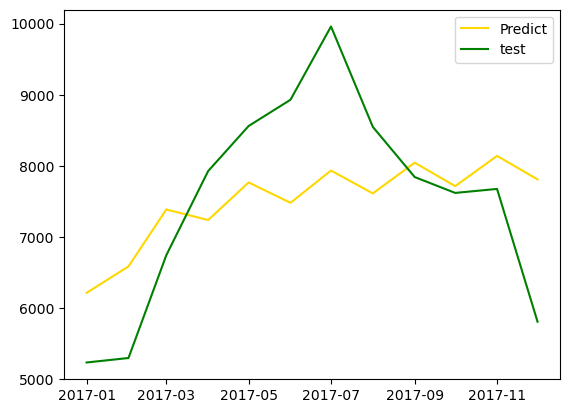

In [39]:
plt.plot(pred_y, color="gold", label='Predict') # 모델이 예상한 가격 그래프
plt.plot(test_y, color="green" , label='test') # 실제 가격 그래프
plt.legend()
plt.show()

제대로 예측하지 못했음을 알 수 있다. R^2값과 RMSE 값을 확인해보자.

In [41]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("r2_score : ", r2_score(test_y, pred_y))
RMSE = mean_squared_error(test_y, pred_y)**0.5
print("RMSE : " , RMSE)

r2_score :  0.35674782271713257
RMSE :  1135.7776639714268


만약 r2_score 값이 음수가 낭오면 해당 모델 정확도가 매우 낮다는 것이다. ARIMA의 경우 긴 값을 예측할 때, 표본평균으로 회귀하려는 경향때문에 작게 나오는 것으로 판단된다.

예제 데이터와 같이 계절성이 있는 경우, 계절성지수가 추가된 SARIMA 모델을 사용하는 것이 좋다.




##### 6) SARIMA
데이터가 지닌 계절성(주기에 따라 유사한 양상으로 변화하는 모양)까지 고려한 모델이다.

- 계절성이 몇개의 데이터 단위로 나타나는지 확인해야 한다. -> 시각화로 판단

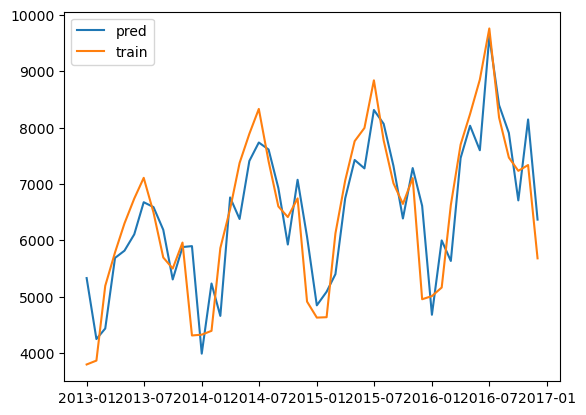

In [42]:
plt.plot(res.predict(), label="pred")
plt.plot(training, label="train")
plt.legend()
plt.show()

이전 분석 결과를 확인하면 1년 단위로 계절성이 존재하는 것으로 보인다. s값은 12로 설정해준다.

그 후 seasonal_order (p,d,q) 파라미터 최적화를 위해 그리드서치를 이용할 수 있다. 패키지를 설치하여 사용하자.

In [43]:
!pip install pmdarima

     -------------------------------------- 568.9/568.9 kB 7.2 MB/s eta 0:00:00
     ------------------------------------- 987.3/987.3 kB 10.4 MB/s eta 0:00:00


In [44]:
from pmdarima import auto_arima

auto_model = auto_arima(training, start_p=0, d=1, start_q=0,
                        max_p=3, max_q=3, 
                        start_P=0, start_Q=0,
                        max_P=3, max_Q=3, m=12,   # m은 sarima의 s값과 동일
                        seasonal=True, information_criterion='aic',
                        trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=481.846, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=482.652, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=482.466, Time=0.10 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=483.637, Time=0.06 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=483.669, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=481.031, Time=0.04 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=482.740, Time=0.11 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=482.616, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=482.682, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=480.687, Time=0.04 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=482.403, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=48

auto_arima 결과 Best model은  ARIMA(0,1,1)(0,1,0)[12] 모델이 최적 모델로 나왔다. arima의 2,0,2 모델과 다른 p, d, q 값을 가짐을 알 수 있다. 계절성이 추가되면서 완전히 다른 학습이 되었다는 이미이다. 해당 모델을 살펴보면

In [45]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -238.344
Date:                             Mon, 06 Mar 2023   AIC                            480.687
Time:                                     19:07:31   BIC                            483.798
Sample:                                 01-01-2013   HQIC                           481.761
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3185      0.177     -1.801      0.072      -0.665       0.028
sigma2      4.803e+04   1.64e+04      2.924      0.003    1.58e+04    8.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.95   Prob(JB):                         0.56
Heteroskedasticity (H):               1.56   Skew:                            -0.14
Prob(H) (two-sided):                  0.45   Kurtosis:                         2.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

AIC가 480인 모델이 최적 모델로 선택되었음을 알 수 있으며 p-value가 0.05보다 작은 MA(1) 변수와 m=12, D=1, Q=1이 적용된 모델임을 확인할 수 있다. => SARIMAX(0, 1, 1)

In [46]:
# 최종 모델로 다시 예측 : auto_arima에는 forecast 함수가 없다.

# 학습 데이터셋으로부터 test 데이터 길이만큼 예측
auto_pred_y= pd.DataFrame(auto_model.predict(n_periods=len(test)), 
                          index=test.index) 
auto_pred_y.columns = ['predicted_price']
auto_pred_y

,predicted_price
day,
2017-01-01,5609.436976
2017-02-01,5761.436976
2017-03-01,7225.436976
2017-04-01,8298.436976
2017-05-01,8841.436976
2017-06-01,9452.436976
2017-07-01,10359.436976
2017-08-01,8777.436976
2017-09-01,8068.436976


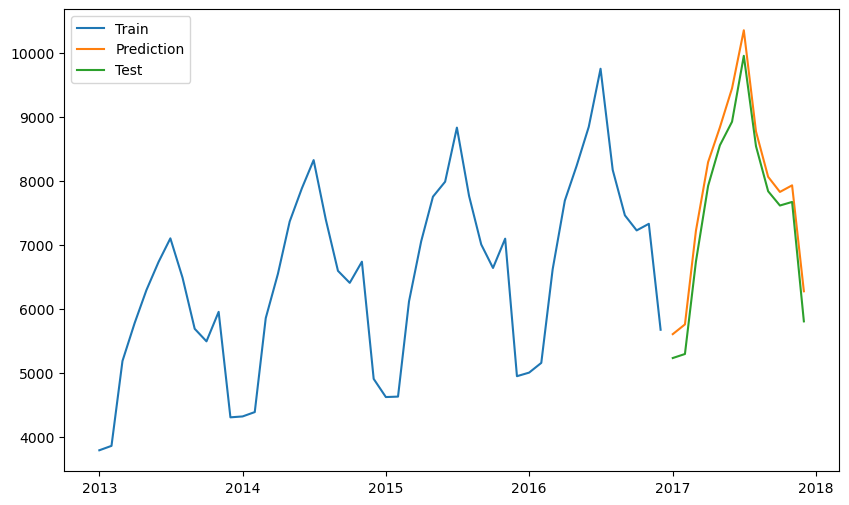

In [47]:
plt.figure(figsize=(10,6))
plt.plot(training, label="Train") # Train 데이터 
plt.plot(auto_pred_y, label="Prediction") # 모델이 예상한 그래프 
plt.plot(test, label="Test") # 실제 가격 그래프 
plt.legend(loc='upper left')
plt.show()

계절성이 존재하는 경우 SARIMA 모델이 정확도가 높은 것을 알 수 있다. 평가지표인 R^2, RMSE 값을 확인하자

In [48]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("r2_score : ", r2_score(test_y, auto_pred_y))
RMSE = mean_squared_error(test_y, auto_pred_y)**0.5
print("RMSE : " , RMSE)

r2_score :  0.9305467069431359
RMSE :  373.2064254331493


SARIMA 모델은 93.1% 의 정확도를 가지고 예측하였으며 평균오차는 373원으로 매우 높은 정확도를 보였다. 즉, 이 데이터는 시간의 추세와 계절성만 가지고 예측할 수 있다는 의미이다. 그러므로 이 데이터(가격)는 시간의 영향을 많이 받는다고 할 수 있다.